In [1]:
# Dependencje
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import fowlkes_mallows_score, davies_bouldin_score, silhouette_score, calinski_harabaz_score
from scipy.cluster.hierarchy import cophenet

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
warnings.filterwarnings('ignore')

# [WUM] Praca domowa nr 6 - klasteryzacja i ocena jakości skupień
### Mateusz Polakowski

W tej pracy domowej zajmiemy się tematem analizy skupień oraz statystykami, które opisują jakość podziału na klastry. 

Do tego weźmy dwa algorytmy wczytane z modułu *sklearn.cluster*: *k-means++* (zmodyfikowany algorytm *k-means*) oraz *DBSCAN* (podejście gęstościowe) - dzięki takiemu wyborowi będzie można zauważyć przypadki w jakich poszczególnych algorytmów można używać. Zbadamy jakość ich klasteryzacji na dwóch zbiorach uzyskanych przy użyciu funkcji modułu *sklearn.datasets*: *make_blobs* oraz *make_moons* (klastry wydzielone różnymi kolorami):

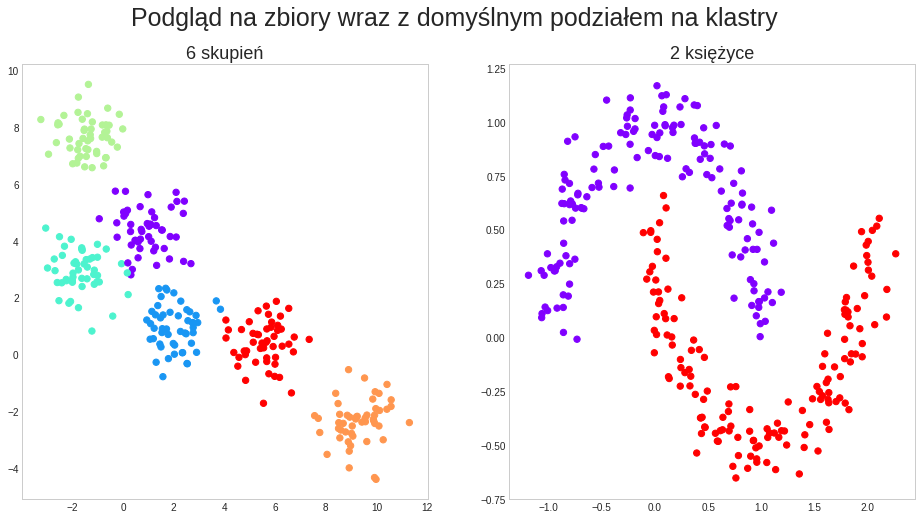

In [2]:
X_blobs, y_blobs = make_blobs(n_samples=300, n_features=2,
                              centers=6, cluster_std=0.75,
                              shuffle=True, random_state=0)
X_moons, y_moons = make_moons(n_samples=300, noise=0.1)

plt.figure(figsize=(16, 8))
plt.suptitle('Podgląd na zbiory wraz z domyślnym podziałem na klastry', fontsize=25)
plt.subplot(121)
plt.title('6 skupień', fontsize=18)
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs, cmap='rainbow', marker='o', s=40)
plt.grid()

plt.subplot(122)
plt.title('2 księżyce', fontsize=18)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='rainbow', marker='o', s=40)
plt.grid()
plt.show()

Jak widać, w zbiorze po lewo chcemy aby zostało znalezionych sześć klastrów, natomiast w tym po prawo dwa. Ponieważ algorytm *k-means* wymaga podania liczby przewidywanych klastrów to przekażemy mu właśnie te wartości, pomijając *elbow plots* (*DBSCAN* sam dedukuje liczbę klastrów).

Oceny jakości klasteryzacji dokonamy przy użyciu 4 z wielu zaproponowanych algorytmów w artykule [On Clustering Validation Techniques](https://www.researchgate.net/publication/2500099_On_Clustering_Validation_Techniques):
* *Folkes and Mallows index* - indeks mierzący podobieństwo dwóch podziałów na skupienia (*external*)
* *Davies-Bouldin index* - im mniejszy, tym lepiej, z dolną granicą w $0$ (*internal*)
* *Silhouette score* - wartości między $[-1, 1]$ (tym razem im większy tym lepiej) (*internal*)
* *Calinski-Harabasz index* (lub *Variance Ratio Criterion*) (*internal*)

Poniżej efekty przeprowadzonej analizy skupień wraz z tabelą przedstawiającą wyniki dla poszczególnych indeksów i algorytmów.

In [3]:
# k-means++
km_blobs = KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
km_moons = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km_blobs = km_blobs.fit_predict(X_blobs)
y_km_moons = km_moons.fit_predict(X_moons)

# dbscan
dbscan_blobs = DBSCAN(eps=1, min_samples=20, metric='euclidean')
dbscan_moons = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
y_dbscan_blobs = dbscan_blobs.fit_predict(X_blobs)
y_dbscan_moons = dbscan_moons.fit_predict(X_moons)

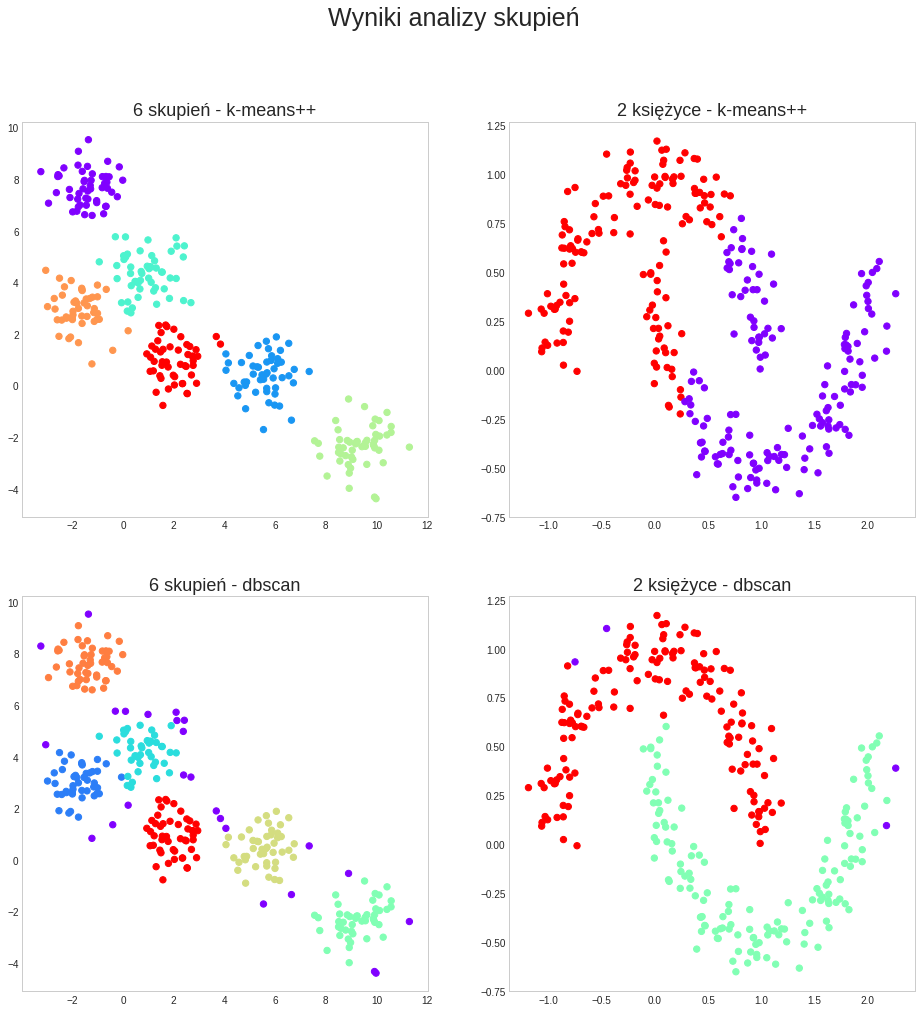

In [4]:
# plotting results
plt.figure(figsize=(16, 16))
plt.suptitle('Wyniki analizy skupień', fontsize=25)

plt.subplot(221)
plt.title('6 skupień - k-means++', fontsize=18)
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_km_blobs, cmap='rainbow', marker='o', s=40)
plt.grid()

plt.subplot(222)
plt.title('2 księżyce - k-means++', fontsize=18)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_km_moons, cmap='rainbow', marker='o', s=40)
plt.grid()

plt.subplot(223)
plt.title('6 skupień - dbscan', fontsize=18)
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_dbscan_blobs, cmap='rainbow', marker='o', s=40)
plt.grid()

plt.subplot(224)
plt.title('2 księżyce - dbscan', fontsize=18)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_dbscan_moons, cmap='rainbow', marker='o', s=40)
plt.grid()

plt.show()

Ze znajomości algorytmu *DBSCAN* wiemy, że fioletowe kropki w obu wykresach wyników klasteryzacji oznaczają *szum* - rekordy, które odbiegają od klastrów na tyle, że nie zostały zakwalifikowane jako część wydzielonych klastrów.

Oba algorytmy efektywnie poradziły sobie z 6 skupieniami. Jest to spowodowane tym, że algorytm *k-means++* dobrze radzi sobie ze skupieniami kulistych kształtów, a *dbscan* znajduje owa skupienia na podstawie zwiększonej gęstości w poszczególnych miejscach.

Inna sytuacja jest w przypadku 2 księżyców. *K-means* zupełnie sobie nie poradziło znajdując dwa klastry, które nie za wiele mają wspólnego z oczekiwaną rzeczywistością. O wiele lepiej poradził sobie *dbscan* znajdując celnie dwa skupienia, dodatkowo usuwając kilka rekordów szumu.

Poza analizą wzrokową wyników klasteryzacji spójrzmy na wyniki wspomnianych wyżej metryk:

In [5]:
pd.DataFrame({
    'blobs_km': [np.round(fowlkes_mallows_score(y_blobs, y_km_blobs), 3),
                 np.round(davies_bouldin_score(X_blobs, y_km_blobs), 3),
                 np.round(silhouette_score(X_blobs, y_km_blobs), 3),
                 np.round(calinski_harabaz_score(X_blobs, y_km_blobs), 3)],
    'blobs_db': [np.round(fowlkes_mallows_score(y_blobs, y_dbscan_blobs), 3),
                 np.round(davies_bouldin_score(X_blobs, y_dbscan_blobs), 3),
                 np.round(silhouette_score(X_blobs, y_dbscan_blobs), 3),
                 np.round(calinski_harabaz_score(X_blobs, y_dbscan_blobs), 3)],
    'moons_km': [np.round(fowlkes_mallows_score(y_moons, y_km_moons), 3),
                 np.round(davies_bouldin_score(X_moons, y_km_moons), 3),
                 np.round(silhouette_score(X_moons, y_km_moons), 3),
                 np.round(calinski_harabaz_score(X_moons, y_km_moons), 3)],
    'moons_db': [np.round(fowlkes_mallows_score(y_moons, y_dbscan_moons), 3),
                 np.round(davies_bouldin_score(X_moons, y_dbscan_moons), 3),
                 np.round(silhouette_score(X_moons, y_dbscan_moons), 3),
                 np.round(calinski_harabaz_score(X_moons, y_dbscan_moons), 3)]
}, index=['Folkes and Mallows', 'Davies-Bouldin', 'Silhouette', 'Calinski-Harabasz'])

,blobs_km,blobs_db,moons_km,moons_db
Folkes and Mallows,0.987,0.897,0.626,0.980
Davies-Bouldin,0.527,1.703,0.779,2.816
Silhouette,0.610,0.537,0.487,0.275
Calinski-Harabasz,1356.500,354.540,438.282,89.645


Ostatecznym wnioskiem jest, że algorytm *k-średnich* może zostać użyty przede wszystkim w sytuacji kulistych, skoncentrowanych klastrów. W innych może sobie, przez swoją implementacyjną prostotę, nie dać rady. Gęstościowe podejście wydaje się bardziej ogólne i celne.